In [1]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch
from MMObject.utls import *
from tqdm import trange

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!


In [2]:
from MMObject.prompt_generator import *
pg0123  = PromptGenerator0123()

In [3]:
instruction = f"""
Your task is to provide a good rationale for the multiple choices question asked by the user based on the image provided. Remember, for the rationale, you should think by step and determine between each choice. The template for the rationale is as follows:

      Question: What is in the motorcyclist's mouth?
      Choices: 0. toothpick 1. food 2. popsicle stick 3. cigarette
      Rationale: 
      Looking at the picture, we can see a man with white shirt riding a motorcycle. Now as we find the motorcyclist in the question, we can see that he has a cigarette in his mouth. 
      Now, let’s analyze the choices:
      0. toothpick: Since the man is riding a bike, there is low chance that there is a toothpick in his mouth.
      1. food: Similary, the man is riding a bike and there is a stick-shape thing in his mouth which probably is not food.
      2. popsicle stick: The color of the object in the man's mouth is not a typical popsicle stick's color. Therefore, popsicle stick might not be the answer.
      3. cigarette: The shape of the object and the color of the object resembles a cigarette. And it's very likely that people will smoke cigarette when motorcyling. Threrfore, cigarette is probably correct.
      Based on the analysis, the most correct answer is cigarette.

      Question: Which number birthday is probably being celebrated?
      Choices: 0. one 1. ten 2. nine 3. thirty
      Rationale: 
      From the question, we know that someone is celebrating a birthday. Observing the picture, we notice two key items on the table: a grey bear-shaped object, likely a decorative cake, and a purple cake adorned with several candles. On closer inspection of the purple cake, the number "thirty" is clearly written on it.
      Now, let’s analyze the choices:
      0. one: There is no indication in the image or on the cake that suggests the number "one" is being celebrated.
      1. ten: Similarly, the number "ten" is not visible or suggested anywhere in the image.
      2. nine: The number "nine" is also not evident on any part of the cake or decorations.
      3. thirty: The number "thirty" is explicitly written on the purple cake, making this the correct answer.
      Based on the analysis, the most correct answer is thirty.

      Question: What best describes the pool of water?
      Choices: 0. frozen 1. fresh 2. dirty 3. boiling
      Rationale: 
      Observing the picture, we notice a tree in the middle, with several giraffes visible behind it. At the bottom of the image, there is a pool of water, which is the pool referred to in the question. The pool appears dark brown in color, muddy, and surrounded by dirt.
      Now, let’s analyze the choices:
      0. frozen: The pool cannot be frozen as the weather is clear and there are no signs of ice on the surface of the water.
      1. fresh: The water does not appear fresh because it is muddy and brown in color.
      2. dirty: The muddy appearance and dark brown color of the water indicate that the pool is dirty.
      3. boiling: The water is not boiling, as there are no signs of steam or bubbling, and the giraffes would not be able to drink boiling water.
      Based on the analysis, the most correct answer is dirty.

      Now, please provide a rationale for the following question based on the image provided:
"""

      # Question: {sample['question']}
      # Choices: {[f"{ind}. {choice}" for ind, choice in enumerate(sample['choices'])]}
      # Correct Answer: {sample['choices'][sample['correct_choice_idx']]}
      # Rationale:

def convert_to_conversation(sample, mode = "train" ):
    split = sample['split']
    base_path = f"/home/ubuntu/data/coco/{split}2017/"
    img_id = sample["image_id"]
    img_file = str(img_id).zfill(12) + ".jpg"
    # ocr_res_text = ocr_res[str(img_id)]
    img_path = base_path + img_file  
    base_ans = sample["correct_choice_idx"]
    rationale =  sample['rationales']
    direct_ans = sample['direct_answers']
    question = sample["question"]
    choices = sample["choices"]
    mcToAsk = pg0123.generate_question(question, choices)
    image = Image.open(img_path)
    if mode == "train":
        reference_rationale = rationale
   
        reference_rationale = sample['gpt_ratioanle'].strip()
        if reference_rationale.startswith("Rationale:"):
            reference_rationale = reference_rationale[10:].strip()
        
        prompt = instruction.strip()+"\n" + mcToAsk.strip() + "\n Rationale:"
        
    #     output = {"instruction": prompt, "output": reference_rationale, "image": [img_path]}
    #     return output
        conversation = [
            { "role": "user",
            "content" : [
                {"type" : "text",  "text"  : prompt},
                {"type" : "image", "image" : image} ]
            },
            { "role" : "assistant",
            "content" : [
                {"type" : "text",  "text"  : reference_rationale} ]
            },
        ]
        return { "messages" : conversation }

    elif mode == "val":
        prompt = instruction.strip()+"\n" + mcToAsk.strip() + "\n Rationale:"
        conversation = [
            { "role": "user",
            "content" : [
                {"type" : "image"},
                {"type" : "text",  "text"  : prompt},
                 ]
            }]
        return conversation, img_path
    
    messages = [
    {"role": "user", 
     "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]




In [4]:
val_aokvqa = prepare_dataset("val")

In [5]:
messages = [convert_to_conversation(sample,mode="val") for sample in val_aokvqa]


In [6]:
sample1 = {'split': 'val', 'image_id': 4795, 'question_id': '2N5sYXgyFqbDnuUhJFAWr5', 'question': 'What is the descriptive word for this surface?', 'choices': ['barren', 'crowded', 'minimalist', 'empty'], 'correct_choice_idx': 1, 'direct_answers': ['desk', 'desktop', 'glossy', 'computer', 'busy', 'crowded', 'table', 'smooth', 'desk', 'cluttered'], 'difficult_direct_answer': True, 'rationales': ['There are many visible objects in a small space without much unused space visible which is consistent with the definition of answer a.', 'There are many object including a cat on the desk space.', 'The area is really crowded and needs some room.']}
converted_sample = convert_to_conversation(sample1,mode="val") 

In [7]:
if True:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!


<string>:204: SyntaxWarning: invalid escape sequence '\ '
<string>:205: SyntaxWarning: invalid escape sequence '\_'
<string>:206: SyntaxWarning: invalid escape sequence '\ '
<string>:204: SyntaxWarning: invalid escape sequence '\ '
<string>:205: SyntaxWarning: invalid escape sequence '\_'
<string>:206: SyntaxWarning: invalid escape sequence '\ '


==((====))==  Unsloth 2024.11.10: Fast Mllama vision patching. Transformers: 4.46.2.
   \\   /|    GPU: NVIDIA A10G. Max memory: 21.975 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


In [9]:
message = converted_sample[0]
message

[{'role': 'user',
  'content': [{'type': 'image'},
   {'type': 'text',
    'text': 'Your task is to provide a good rationale for the multiple choices question asked by the user based on the image provided. Remember, for the rationale, you should think by step and determine between each choice. The template for the rationale is as follows:\n\n      Question: What is in the motorcyclist\'s mouth?\n      Choices: 0. toothpick 1. food 2. popsicle stick 3. cigarette\n      Rationale: \n      Looking at the picture, we can see a man with white shirt riding a motorcycle. Now as we find the motorcyclist in the question, we can see that he has a cigarette in his mouth. \n      Now, let’s analyze the choices:\n      0. toothpick: Since the man is riding a bike, there is low chance that there is a toothpick in his mouth.\n      1. food: Similary, the man is riding a bike and there is a stick-shape thing in his mouth which probably is not food.\n      2. popsicle stick: The color of the object in 

In [10]:


message = converted_sample[0]
image = Image.open(converted_sample[1])

input_text = tokenizer.apply_chat_template(message, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")
res = []
# from transformers import TextStreamer
for i in range(1):
    # text_streamer = TextStreamer(tokenizer, skip_prompt = True)
    _ = model.generate(**inputs, max_new_tokens = 1000,
                    use_cache = True, temperature = 0.5, min_p = 0.2)

    res.append(tokenizer.decode(_[0], skip_special_tokens = True)[-100:])

In [11]:
res

['phasizes simplicity and essentiality.\n\nBased on the analysis, the most correct answer is minimalist.',
 'implicity or minimalism of the setup.\n\nBased on the analysis, the most correct answer is minimalist.',
 ' empty enough to describe it as such.\n\nBased on the analysis, the most correct answer is minimalist.',
 ' empty, as there are objects present.\n\nBased on the analysis, the most correct answer is minimalist.',
 'objects like the computer and cat present.\n\nBased on the analysis, the most correct answer is empty.']

In [ ]:

image = dataset[0]["image"]
instruction = "You are an expert radiographer. Describe accurately what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

In [76]:
res

['visible elements like text and icons.\n\nBased on the analysis, the most correct answer is minimalist.',
 'ible items such as the laptop and the cat.\n\nBased on the analysis, the most correct answer is empty.',
 'nt, such as the computer and the cat.\n\nBased on the analysis, the most correct answer is minimalist.',
 's there are still some items present.\n\nBased on the analysis, the most correct answer is minimalist.',
 'ts like a laptop and a phone present.\n\nBased on the analysis, the most correct answer is minimalist.',
 'ot the case since there is a cat present.\n\nBased on the analysis, the most correct answer is barren.',
 'ty, as there are still visible items.\n\nBased on the analysis, the most correct answer is minimalist.',
 'ic of simplicity and lack of clutter.\n\nBased on the analysis, the most correct answer is minimalist.',
 'he laptop screen and the cat present.\n\nBased on the analysis, the most correct answer is minimalist.',
 'ty as there are some objects presen

In [26]:
print(tokenizer.decode(_[0], skip_special_tokens = True))

user

Your task is to provide a good rationale for the multiple choices question asked by the user based on the image provided. Remember, for the rationale, you should think by step and determine between each choice. The template for the rationale is as follows:

      Question: What is in the motorcyclist's mouth?
      Choices: 0. toothpick 1. food 2. popsicle stick 3. cigarette
      Rationale: 
      Looking at the picture, we can see a man with white shirt riding a motorcycle. Now as we find the motorcyclist in the question, we can see that he has a cigarette in his mouth. 
      Now, let’s analyze the choices:
      0. toothpick: Since the man is riding a bike, there is low chance that there is a toothpick in his mouth.
      1. food: Similary, the man is riding a bike and there is a stick-shape thing in his mouth which probably is not food.
      2. popsicle stick: The color of the object in the man's mouth is not a typical popsicle stick's color. Therefore, popsicle stick might

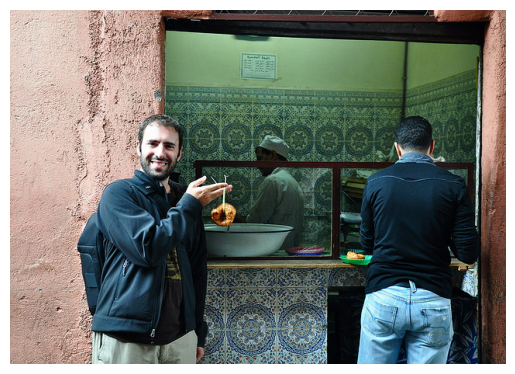

Question: What type of pants is the man on the right wearing?
Choices: 0. linen 1. corduroy 2. silk 3. denim
Correct Answer: denim
Direct Answers: ['jeans', 'blue jeans', 'jeans', 'denim', 'jeans', 'jeans', 'jeans', 'jeans', 'jeans', 'blue jeans']
Rationale: ['The man is wearing blue pants that have the style and look to be of the consistency of jeans and denim.', 'The colour and design is consistent of that of denim jeans.', 'The man is wearing denim because he is wearing jeans which are made out of denim']


In [30]:
demonstrate_example(val_aokvqa[9])